In [1]:
import torch
import numpy as np
import os
import cv2
from tqdm import tqdm

In [9]:
# images data prepare, all images and labels saved inside images_data.npy 
class traffic_signal_image():
    IMAGE_SIZE = 28
    data = []
    images_path = os.getcwd() + '\\' + 'Train'
    classes = 43
    
    def image_prepare(self):
        for i in range(self.classes):
            path = os.path.join(self.images_path,str(i))
            for image in tqdm(os.listdir(path)):
                if 'png' in image:
                    try :
                        img_path = os.path.join(path + '/',image) 
                        img = cv2.imread(img_path)
                        img = cv2.resize(img,(self.IMAGE_SIZE,self.IMAGE_SIZE))
                        img = np.array(img)      # shape (28, 28, 3)
                        self.data.append([img,i])
                    except:
                        print("Can not open an image")
        self.data = np.array(self.data)
        np.random.shuffle(self.data)
        np.save("images_data.npy",self.data)
        #print(self.data.shape)      #shape (39209, 2)
        
traffic_signal_image = traffic_signal_image()
traffic_signal_image.image_prepare()




100%|██████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1467.45it/s]


In [10]:
# nn model define
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(1600,128)
        self.fc2 = nn.Linear(128,43)
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = F.max_pool2d(F.relu(x),(2,2))
        x = self.conv2(x)
        x = F.max_pool2d(F.relu(x),(2,2))
        #print(x.shape)
        x = x.view(-1,1600)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x                 # CrossEntropyloss doesn't use the softmax()
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=43, bias=True)
)


In [4]:
# divided train/test images 9:1

traindata = np.load("images_data.npy",allow_pickle=True)

X = torch.tensor([i[0] for i in traindata],dtype=torch.float32).view(-1,3,28,28)
X = X/255
y = torch.tensor([i[1] for i in traindata],dtype=torch.long)

TEST_PCT = 0.1
TEST_SIZE = int(TEST_PCT * (len(X)))

train_X = X[:-TEST_SIZE]
train_y = y[:-TEST_SIZE]

test_X = X[-TEST_SIZE:]
test_y = y[-TEST_SIZE:]

In [5]:
# train and save accuracy/loss along the trainning process
def train_check_accuracy(X,y,train=False):
    if train:
        net.zero_grad()
    output = net(X)
    matches = [torch.argmax(output[i]) == y[i] for i in range(len(output))]
    correct = matches.count(True)
    total = len(matches)
    accuracy = 100*correct/total
    loss = loss_function(output,y)
    
    if train:
        loss.backward()
        optimizer.step()

    return accuracy,loss

def validation_accuracy(size=50):
    X,y = test_X[:size],test_y[:size]
    val_acc,val_loss = train_check_accuracy(X,y,train=False)
    return val_acc,val_loss


In [6]:
# distinguish the saving information by time as model name
import time
model_name = f"model_{int(time.time())}"
print(model_name)

model_1607811970


In [8]:
# train and save acc/loss in train_model.log
import torch.optim as optim
net = Net()
optimizer  = optim.Adam(net.parameters(), lr = 0.001 )   # sometimes if the loss is not changed over trainning, reduced the lr to try it
loss_function = nn.CrossEntropyLoss()

def train_vis(net):
    batch_size = 32
    epochs = 5
    with open("train_model.log","a") as f:
        for epoch in range(epochs):
            for i in tqdm(range(0,len(train_X),batch_size)):
                batch_X = train_X[i:i+batch_size].view(-1,3,28,28)
                batch_y = train_y[i:i+batch_size]
                acc,loss = train_check_accuracy(batch_X,batch_y,train=True) 
                
                if i%10 == 0:
                    val_acc,val_loss = validation_accuracy(size=100)
                    f.write(f"{model_name},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")                    

train_vis(net)               

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1103/1103 [00:44<00:00, 24.91it/s]


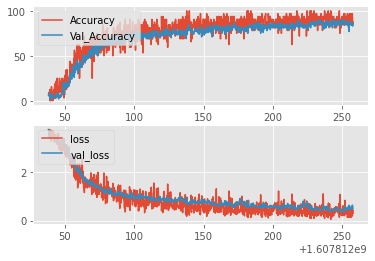

In [9]:
# visualization accuracy/loss in the trainning procss in train_model.log
# which can see that the accuracy is about 90% in the test data.
from matplotlib import pyplot as plt

plt.style.use("ggplot")

# the model_name above
model_name = "model_1607811970"

def acc_loss_visualization(model_name):
    contents = open('train_model.log','r').read().split('\n')
    
    times = []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []
    
    for line in contents:
        if model_name in line:
            name,timepoint,accuracy,loss,val_acc,val_loss = line.split(',')
            
            times.append(float(timepoint))
            accuracies.append(float(accuracy))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
            
    fig = plt.figure()
    
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    
    ax1.plot(times,accuracies,label='Accuracy')
    ax1.plot(times,val_accs,label='Val_Accuracy')
    ax1.legend(loc=2)
    ax2.plot(times,losses,label='loss')
    ax2.plot(times,val_losses,label='val_loss')
    ax2.legend(loc=2)
    plt.show()

acc_loss_visualization(model_name)